## Installing and importing necessary libraries

In [1]:
!pip install -q transformers datasets peft accelerate bitsandbytes trl huggingface_hub

In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, TaskType
from datasets import load_dataset
from trl import SFTTrainer
import torch

## Model and tokenizer Initialization

* Defines the model name as "TinyLlama/TinyLlama-1.1B-Chat-v1.0", a lightweight, chat-optimized language model suitable for resource-constrained environments like Raspberry Pi.

* Loads the tokenizer using AutoTokenizer, ensuring fast tokenization and setting the padding token to the model's end-of-sequence (eos) token for compatibility.

* Loads the TinyLlama model for causal language modeling with AutoModelForCausalLM.

    * device_map="auto" automatically selects the best device (CPU/GPU).
    * torch_dtype=torch.bfloat16 uses bfloat16 precision for efficient computation.
    * trust_remote_code=True allows loading custom code from the model repository.

This setup guarantees that the TinyLlama model is ready for further fine-tuning and training steps, optimized for use in a voice-activated home automation system.

In [3]:
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    trust_remote_code=True
)

`torch_dtype` is deprecated! Use `dtype` instead!


## PEFT with LoRA

This cell configures the model for parameter-efficient fine-tuning (PEFT) using Low-Rank Adaptation (LoRA).

#### Model preparation
The base TinyLlama model is adapted for low-bit (k-bit) training through prepare_model_for_kbit_training, which optimizes it for memory-efficient fine-tuning.

#### LoRA configuration
The LoraConfig specifies hyperparameters:

* Rank (r=32) and scaling factor (lora_alpha=64) determine the capacity and influence of the low-rank matrices.
* Target modules (q_proj, k_proj, v_proj, o_proj, up_proj, down_proj) indicate where LoRA adapters are injected within the transformer architecture.
* Dropout (0.05) adds regularization to prevent overfitting.
* Bias is excluded to reduce parameter count.
* Task type is set as CAUSAL_LM to align with autoregressive language modeling.

#### Integration with PEFT
The LoRA configuration is applied to the model using get_peft_model, which introduces trainable adapter layers while keeping most of the original model weights frozen. Finally, print_trainable_parameters() reports the number of trainable parameters, confirming the efficiency of this approach.

Purpose: This step enables efficient fine-tuning of TinyLlama by training only a small subset of parameters (LoRA adapters), significantly reducing computational cost and memory requirements compared to full model fine-tuning.

In [4]:
model = prepare_model_for_kbit_training(model)

lora_config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "up_proj", "down_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.CAUSAL_LM
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 19,824,640 || all params: 1,119,873,024 || trainable%: 1.7703


In [5]:
dataset = load_dataset("acon96/Home-Assistant-Requests")
train_data = dataset["train"]
eval_data = dataset["test"]

In [6]:
import transformers
print(transformers.__version__)

4.56.0


In [7]:
from transformers import TrainingArguments
print(TrainingArguments.__module__)

transformers.training_args


In [8]:
from transformers import TrainingArguments

args = TrainingArguments(
    output_dir="./check",
    eval_strategy="steps",
)

## Training Configuration

This cell defines the training hyperparameters and runtime settings for fine-tuning TinyLlama using the Hugging Face TrainingArguments class. The key configurations are as follows:

* **Epochs and batch size:** Training is conducted for 2 epoch, with per-device batch sizes of two for both training and evaluation. Gradient accumulation over 32 steps effectively increases the batch size without exceeding GPU memory constraints.

* **Evaluation and checkpointing:** The evaluation and saving strategies are step-based. Checkpoints are saved every 100 steps, evaluations occur every 50 steps, and a maximum of 20 checkpoints are retained to manage storage.

* **Optimization parameters:** The learning rate is set to 1e-5, with a warm-up ratio of 0.03 for stabilizing convergence during the early phase of training. Gradient checkpointing is enabled to reduce memory usage by recomputing intermediate activations.

* **Precision and efficiency:** Training leverages bfloat16 (bf16) precision for faster computation and reduced memory footprint. Sequence grouping by length (group_by_length=True) is used to minimize padding overhead and improve efficiency.

* **Other settings:** max_steps=-1 ensures training continues until the designated number of epochs is completed, rather than being step-limited.

**Purpose:** This configuration establishes an optimized fine-tuning environment, balancing efficiency, checkpointing, and evaluation to adapt TinyLlama for domain-specific voice-based home automation tasks.

In [7]:
training_args = TrainingArguments(
    output_dir="./tinyllama-1.1b-lora",
    run_name="home-llm",
    num_train_epochs=2,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=32,  # 64 / 2
    eval_strategy="steps",
    save_strategy="steps",
    save_steps=100,
    eval_steps=50,
    logging_steps=2,
    save_total_limit=20,
    learning_rate=1e-5,
    warmup_ratio=0.03,
    bf16=True,
    logging_dir="./logs",
    gradient_checkpointing=True,
    group_by_length=True,
    max_steps=-1,
)

The chosen hyperparameters are motivated by the resource constraints of deployment platforms such as **Raspberry Pi:**

* A **low learning rate** ensures stable convergence when adapting a large pre-trained model to a smaller, domain-specific dataset, preventing overfitting and catastrophic forgetting.

* **Gradient accumulation** enables the simulation of a larger effective batch size despite limited GPU memory, making the fine-tuning process feasible on modest hardware setups.

* Memory-efficient techniques such as **bfloat16 precision** and gradient checkpointing mirror the optimization strategies required when deploying on edge devices with limited computational resources.

In [14]:
!pip install --upgrade "jinja2"

Defaulting to user installation because normal site-packages is not writeable


In [10]:
!pip show jinja2

Name: Jinja2
Version: 3.1.6
Summary: A very fast and expressive template engine.
Home-page: 
Author: 
Author-email: 
License: 
Location: /home/ubuntu/.local/lib/python3.10/site-packages
Requires: MarkupSafe
Required-by: jupyter_server, jupyterlab, jupyterlab_server, nbconvert, torch


## Supervised Fine-Tuning execution

This cell initiates the supervised fine-tuning (SFT) process using the SFTTrainer class from the TRL (Transformers Reinforcement Learning) library.
The fine-tuning is configured with the LoRA-adapted TinyLlama model, training and evaluation datasets (train_data and eval_data), and the previously defined training_args.

In [8]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    #tokenizer = tokenizer,
    train_dataset=train_data,
    eval_dataset=eval_data,
    args=training_args,
    #max_seq_length=2048,
    #packing=False
)

# Set tokenizer after initialization
trainer.tokenizer = tokenizer

trainer.train()

Trainer.tokenizer is now deprecated. You should use `Trainer.processing_class = processing_class` instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 2}.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss,Validation Loss
50,1.776100,1.351045
100,0.769100,0.820795
150,0.576900,0.675414
200,0.499000,0.604630
250,0.485400,0.556057
300,0.441500,0.518578
350,0.444900,0.487794
400,0.411300,0.460252
450,0.399300,0.438027
500,0.384100,0.421315


TrainOutput(global_step=1044, training_loss=0.5305675562770887, metrics={'train_runtime': 19333.327, 'train_samples_per_second': 3.451, 'train_steps_per_second': 0.054, 'total_flos': 3.2632662504994406e+17, 'train_loss': 0.5305675562770887})

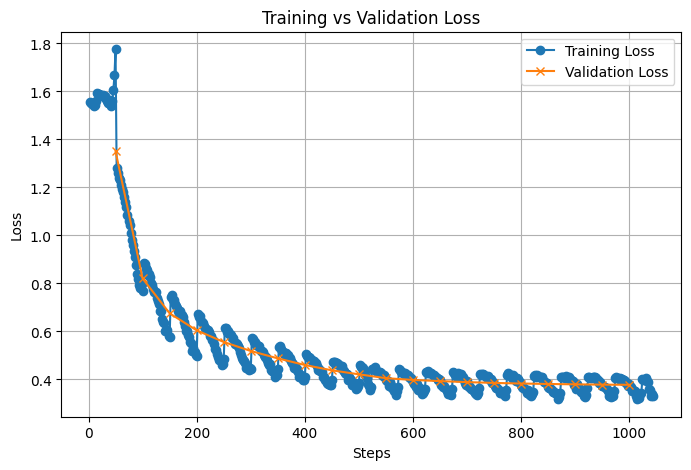

In [9]:
import matplotlib.pyplot as plt

# Collect logs from trainer
logs = trainer.state.log_history

train_steps = []
train_losses = []
eval_steps = []
eval_losses = []

for entry in logs:
    if "loss" in entry and "step" in entry:
        train_steps.append(entry["step"])
        train_losses.append(entry["loss"])
    if "eval_loss" in entry and "step" in entry:
        eval_steps.append(entry["step"])
        eval_losses.append(entry["eval_loss"])

plt.figure(figsize=(8, 5))
plt.plot(train_steps, train_losses, label="Training Loss", marker='o')
plt.plot(eval_steps, eval_losses, label="Validation Loss", marker='x')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


### Results interpretation - Training 2

**Setup:**

* r=32, lora_alpha=64
* lr = 1e-5
* batch size: 2 × 32 = 64
*epochs: 2

**Loss curve:**

* Training loss: 1.77 → 0.37
* Validation loss: 1.35 → 0.37
  
**Observations** 

* Loss steadily decreased (good).
* Ended around 0.37 val loss, which is respectable.
* But learning was slower and plateaued at ~0.37, meaning it's underfitting slightly.

## Saving the trained model

In [12]:
# Save Final Model
trainer.save_model("./tinyllama-1.1b-lora-final")
tokenizer.save_pretrained("./tinyllama-1.1b-lora-final")

('./tinyllama-1.1b-lora-final/tokenizer_config.json',
 './tinyllama-1.1b-lora-final/special_tokens_map.json',
 './tinyllama-1.1b-lora-final/chat_template.jinja',
 './tinyllama-1.1b-lora-final/tokenizer.json')

# Brief Evaluation

In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import pandas as pd

In [2]:
model_path = "./tinyllama-1.1b-lora-final" 
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForCausalLM.from_pretrained(model_path, torch_dtype=torch.float16, device_map="auto")


In [3]:
SYSTEM_PROMPT = """You are 'Al', a helpful AI Assistant that controls the devices in a house. Complete the following task as instructed or answer the following question with the information provided only.
Services: cover.close_cover(), cover.open_cover(), cover.stop_cover(), cover.toggle(), climate.set_fan_mode(fan_mode), climate.set_humidity(humidity), climate.set_hvac_mode(), climate.set_preset_mode(), climate.set_temperature(temperature), climate.toggle(), climate.turn_off(), climate.turn_on(), fan.decrease_speed(), fan.increase_speed(), fan.toggle(), fan.turn_off(), fan.turn_on(), light.toggle(), light.turn_off(), light.turn_on(rgb_color,brightness), lock.lock(), lock.unlock(), media_player.media_next_track(), media_player.media_pause(), media_player.media_play(), media_player.media_play_pause(), media_player.media_previous_track(), media_player.media_stop(), media_player.toggle(), media_player.turn_off(), media_player.turn_on(), media_player.volume_down(), media_player.volume_mute(), media_player.volume_up(), switch.toggle(), switch.turn_off(), switch.turn_on(), timer.add_item(item), timer.cancel(), timer.pause()
Devices:
lock.home_theater 'Home Theater Lock' = unlocked
media_player.samsung_qled_tv 'Samsung Quantum Dot TV' = off
climate.nest_learning 'Nest Learning Thermostat' = off;On High;75F;67%
switch.closet_lighting 'Closet lighting control' = off
switch.study_room_lights 'Study Room Lights Switch' = off
media_player.harman_kardon_aura 'Harman Kardon Glass Speaker' = off
light.back_zen_warm 'Back Zen Light' = on;gray (146, 120, 139);69%
light.kitchen_island_cool 'Kitchen Island Cool Light' = on;darkolivegreen (78, 109, 32);42%
media_player.study_room_audio_book_player 'Study Audio Book Player' = off
light.study_3 'Study Lights' = on;deepskyblue (10, 194, 244);45%
fan.bathroom_down 'Fan in downstairs bathroom' = off
lock.wine_cellar 'Wine Cellar Lock' = unlocked
media_player.entryway_voice_assistant 'Entryway Voice Assistant' = playing;No Manches Frida;vol=0.22
light.back_observatory_warm 'Back Observatory Warm Light' = on;silver (199, 172, 207)
lock.vehicle_gate 'Vehicle gate lock' = unlocked
todo.home_renovation_planner 'Home renovation scheduler' = 17
cover.sunroom 'Sunroom Blinds' = closed
light.garden 'Garden Light' = on;chocolate (236, 93, 25);41%
light.upstairs_playroom_zwave 'Upstairs Playroom Light' = on;plum (194, 142, 215);10%
lock.workshop_cabinet 'Workshop cabinet lock' = locked
media_player.lounge_hi_fi_system 'Lounge Hi-Fi Audio' = on;Nosferatu: Kino Classics;vol=0.22
light.back_family_room_warm 'Back Family Room Warm Light' = off
cover.kitchen 'Kitchen' = closed
light.back_arcade_warm 'Back Arcade Warm Light' = off;60%
light.upstairs_closet_zwave 'Upstairs Closet Light' = off;yellowgreen (131, 188, 85);95%
light.downstairs_cinema_mqtt 'Downstairs Cinema Light' = off;lightseagreen (13, 159, 192);91%
light.front_arcade_ge 'Front Arcade Light' = on;13%
"""

def build_prompt(user_input):
    return f"<|system|>\n{SYSTEM_PROMPT.strip()}\n<|user|>\n{user_input.strip()}\n<|assistant|>\n"


In [4]:
# Add your user inputs here
user_inputs = [
    "lower the kitchen blinds",
    "turn off all the lights",
    "lock the wine cellar",
    "play some music in the lounge",
    "set the thermostat to 70F"
]

results = []

for user_input in user_inputs:
    prompt = build_prompt(user_input)
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    outputs = model.generate(
        **inputs,
        max_new_tokens=100,
        temperature=0.7,
        do_sample=True,
        top_p=0.9,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.pad_token_id
    )

    decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
    model_response = decoded_output.split("<|assistant|>")[-1].strip()
    #model_response = decoded_output

    print(f"\n[User]: {user_input}\n[Model Response]: {model_response}")
    results.append({
        "user_input": user_input,
        "model_response": model_response
    })



[User]: lower the kitchen blinds
[Model Response]: downing the blinds.
```

[User]: turn off all the lights
[Model Response]: sure, here comes the light turn-off.

[User]: lock the wine cellar
[Model Response]: wine cellar locked

[User]: play some music in the lounge
[Model Response]: starting with 'chocolate'
```

[User]: set the thermostat to 70F
[Model Response]: setting the thermostat to 70F
```
